<a href="https://colab.research.google.com/github/devsTudu/RyzenTech_task2/blob/main/Online_Payments_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Getting Data

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'online-payments-fraud-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2093649%2F3478314%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T131954Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95e9acfd5e8b345bd95edac46c7217158ee773892c94b7dbfd4017b6b285657874e0bf8d2ed034156ab40ebbccec0e1d7b3e9fd4245935f8c4b0b151526f2b046b8f4c5ff764c4c3abcdf22c74685797e0db2611aaffb18242f58c480dc319120cb1b2f57d36d6ea277bd465a63094f4fcf9b6103b803b2b2818af464f6806f8d223f968e1da728e4a4066795544751b7dc38ba06f2239b195231c08a47dfd2ee35eaccd045c06fc793eb811043a54c3d5fb6043c3a0593ed07db233d581c069d97f3234fef48850d322676c8865e30665708c73277091389ee5a84a97fb187b1822932d5ba30a757a924502248a1b3b1f94aa0d47e02f7cd782b3b732bc5b05'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 186385561 bytes downloaded
Downloaded and uncompressed: online-payments-fraud-detection-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv


In [ ]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Pre-Processing

In [ ]:
# loading the dataset into pandas dataframe
df = pd.read_csv("/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


1. Identifying unusual patterns

In [ ]:
df[['type','isFraud',"isFlaggedFraud"]].value_counts()

type      isFraud  isFlaggedFraud
CASH_OUT  0        0                 2233384
PAYMENT   0        0                 2151495
CASH_IN   0        0                 1399284
TRANSFER  0        0                  528812
DEBIT     0        0                   41432
CASH_OUT  1        0                    4116
TRANSFER  1        0                    4081
                   1                      16
Name: count, dtype: int64

In [ ]:
df[["isFlaggedFraud","isFraud"]].value_counts()

isFlaggedFraud  isFraud
0               0          6354407
                1             8197
1               1               16
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.loc[df["isFlaggedFraud"]==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [ ]:
# Checking whether all that is tagged Fraud has  0 in their NewBalanceinDestination
zerobal = df[df.newbalanceDest==0]["isFraud"]
print(zerobal.value_counts())
nozerobal = df[df.newbalanceDest>0]["isFraud"]
nozerobal.value_counts()

isFraud
0    2435342
1       4091
Name: count, dtype: int64


isFraud
0    3919065
1       4122
Name: count, dtype: int64

In [ ]:
diff_in_bal = df.newbalanceDest- df.oldbalanceDest
df[diff_in_bal<0][["type","isFraud"]].value_counts()

type      isFraud
CASH_IN   0          1194479
CASH_OUT  0            38994
TRANSFER  0             3930
DEBIT     0             1434
CASH_OUT  1               26
TRANSFER  1                1
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df = df.drop(['nameOrig','nameDest'],axis=1)

In [ ]:
df = df[df['type'].isin(['TRANSFER','CASH_OUT'])]


In [ ]:
df.loc[:,'diffInBalDest'] = abs(df["newbalanceDest"] - df["oldbalanceDest"])

<ipython-input-42-dd7dc597ad03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'diffInBalDest'] = abs(df["newbalanceDest"] - df["oldbalanceDest"])


In [ ]:
df.loc[:,'diffInBalOrig'] = abs(df["newbalanceOrig"] - df["oldbalanceOrg"])

In [ ]:
df.type = (df.type == "TRANSFER").astype(int)

# Plot fraud with different categorical datas

In [ ]:
df.corr()["isFraud"]

step              0.048671
type              0.042400
amount            0.070660
oldbalanceOrg     0.347582
newbalanceOrig    0.063557
oldbalanceDest   -0.014960
newbalanceDest   -0.008978
isFraud           1.000000
isFlaggedFraud    0.044072
diffInBalDest     0.017859
diffInBalOrig     0.474628
Name: isFraud, dtype: float64

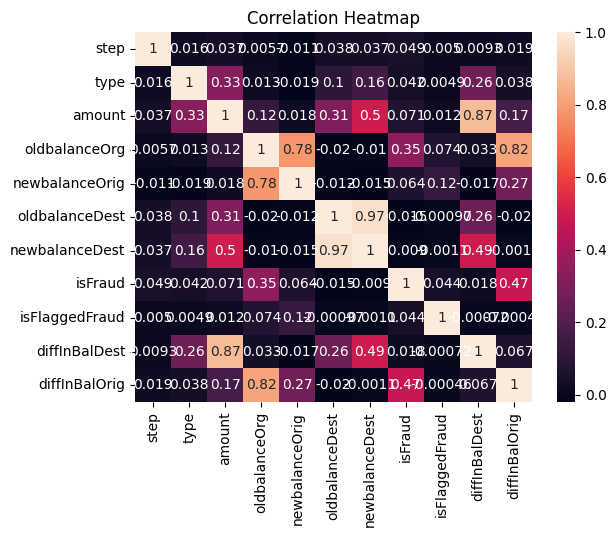

In [ ]:
import seaborn as sns

#HeatMap
corr_mat = df.corr()
sns.heatmap(corr_mat,annot=True)
plt.title("Correlation Heatmap")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'step'),
  Text(1, 0, 'type'),
  Text(2, 0, 'amount'),
  Text(3, 0, 'oldbalanceOrg'),
  Text(4, 0, 'newbalanceOrig'),
  Text(5, 0, 'oldbalanceDest'),
  Text(6, 0, 'newbalanceDest'),
  Text(7, 0, 'isFraud'),
  Text(8, 0, 'isFlaggedFraud'),
  Text(9, 0, 'diffInBalDest'),
  Text(10, 0, 'diffInBalOrig')])

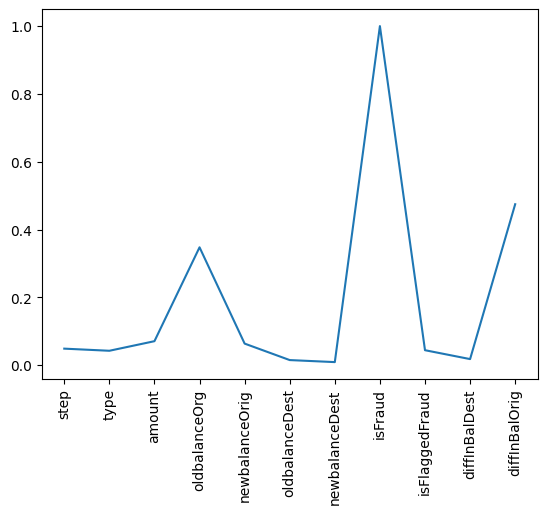

In [ ]:
plt.plot(abs(corr_mat['isFraud']))
plt.xticks(rotation=90)

### Sampling
**Equal Distribution Sampling**

In [ ]:

sample_df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = sample_df.loc[df['isFraud'] == 1]
non_fraud_df = sample_df.loc[df['isFraud'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
print('Distribution of the Classes in the subsample dataset')
print(new_df['isFraud'].value_counts()/len(new_df))

Distribution of the Classes in the subsample dataset
isFraud
0    0.5
1    0.5
Name: count, dtype: float64


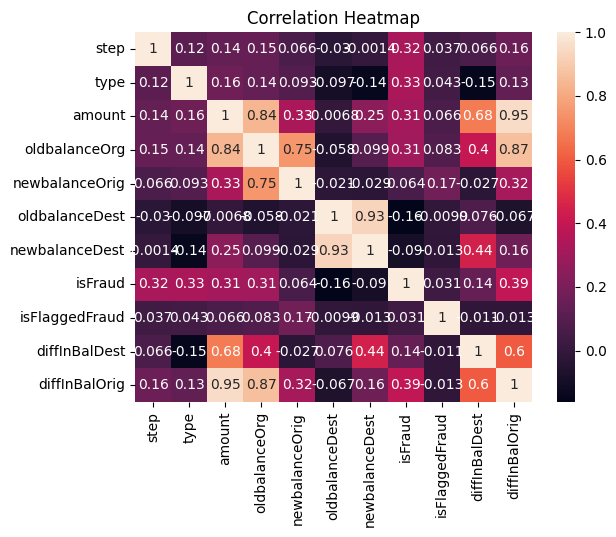

In [ ]:
corr_mat = new_df.corr()
sns.heatmap(corr_mat,annot=True)
plt.title("Correlation Heatmap")
plt.show()

### Testing the Models

In [ ]:
# Load the features to a variable X
# X is created by simply dropping the diagnosis column and retaining all others
X = df.drop('isFraud',axis=1)


#Load the target variable to y
y = df['isFraud']

# Do the train/test split

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)

# Compute Model Accuracy.

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def modelAccuracy(classifier):
    classifier.fit(X_train,y_train)
    y_predict = classifier.predict(X_test)
    y_train_pred = classifier.predict(X_train)

    print("Model Accuracy on Train Data :",accuracy_score(y_train,y_train_pred))
    print("Model Accuracy on Test Data :",accuracy_score(y_test,y_predict))
    #y_test_proba = classifier.predict_proba(X_test)



    cm = confusion_matrix(y_test,y_predict)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    recall = TP / (TP + FN )
    print("Recall= ",recall)

    print(classification_report(y_test,y_predict))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:

LR = LogisticRegression (solver='liblinear',max_iter=200)

In [ ]:
modelAccuracy(LR)

Model Accuracy on Train Data : 0.9976145859868013
Model Accuracy on Test Data : 0.9975454896567656
Recall=  0.5078597339782346
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       0.61      0.51      0.55      2481

    accuracy                           1.00    831123
   macro avg       0.80      0.75      0.78    831123
weighted avg       1.00      1.00      1.00    831123



In [ ]:
DecisionTreeModel = DecisionTreeClassifier(criterion='gini',max_depth=5,random_state=33)
modelAccuracy(DecisionTreeModel)

Model Accuracy on Train Data : 0.9990713076874684
Model Accuracy on Test Data : 0.9990566979857374
Recall=  0.728335348649738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       0.94      0.73      0.82      2481

    accuracy                           1.00    831123
   macro avg       0.97      0.86      0.91    831123
weighted avg       1.00      1.00      1.00    831123



In [ ]:
RandomForestModel = RandomForestClassifier(criterion = 'gini',n_estimators=200,max_depth=5,random_state=33, n_jobs=-1)
modelAccuracy(RandomForestModel)

Model Accuracy on Train Data : 0.9990553224227886
Model Accuracy on Test Data : 0.9990302277761535
Recall=  0.6823861346231358
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       0.99      0.68      0.81      2481

    accuracy                           1.00    831123
   macro avg       0.99      0.84      0.90    831123
weighted avg       1.00      1.00      1.00    831123



**Conclusion**
* Comparing the models we get that the Recall Score works best in the Decision Tree Model

# Running Neural Networks in Sample Data

In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X = df.drop('isFraud',axis=1)
y = df['isFraud']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 32)                352       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 528 (2.06 KB)
Trainable params: 528 (2.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import keras
print(keras.backend.backend())  # Output: tensorflow

tensorflow


In [ ]:
with tf.device('/device:GPU:0'):
  undersample_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)


Epoch 1/20
62058/62058 - 208s - loss: 342.2863 - accuracy: 0.9948 - val_loss: 12.5517 - val_accuracy: 0.9970 - 208s/epoch - 3ms/step
Epoch 2/20
62058/62058 - 179s - loss: 10.3506 - accuracy: 0.9970 - val_loss: 2.9933 - val_accuracy: 0.9969 - 179s/epoch - 3ms/step
Epoch 3/20
62058/62058 - 190s - loss: 6.4287 - accuracy: 0.9969 - val_loss: 21.5902 - val_accuracy: 0.9970 - 190s/epoch - 3ms/step
Epoch 4/20
62058/62058 - 189s - loss: 1.6066 - accuracy: 0.9970 - val_loss: 0.0213 - val_accuracy: 0.9970 - 189s/epoch - 3ms/step
Epoch 5/20
62058/62058 - 175s - loss: 0.4679 - accuracy: 0.9970 - val_loss: 0.0211 - val_accuracy: 0.9970 - 175s/epoch - 3ms/step
Epoch 6/20


KeyboardInterrupt: 

In [ ]:
undersample_model.evaluate(X_test, y_test)

25973/25973 [==============================] - 58s 2ms/step - loss: 0.0407 - accuracy: 0.9970


[0.04069466516375542, 0.9970148801803589]